#### Make sure you have Xgboost installed 

In [6]:
#import libraries
from datetime import datetime, timedelta,date
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
%matplotlib inline
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from __future__ import division
from sklearn.cluster import KMeans


import plotly.graph_objs as go
import plotly.offline as pyoff

from sklearn.model_selection import KFold, cross_val_score, train_test_split


In [7]:
df_data = pd.read_csv('data/telco_churn.csv')

Encoding target variable

In [8]:
df_data.loc[df_data.Churn=='No','Churn'] = 0 
df_data.loc[df_data.Churn=='Yes','Churn'] = 1

### Plotting

In [9]:
df_plot = df_data.groupby('gender').Churn.mean().reset_index()
plot_data = [
    go.Bar(
        x=df_plot['gender'],
        y=df_plot['Churn'],
        width = [0.5, 0.5],
        marker=dict(
        color=['green', 'blue'])
    )
]
plot_layout = go.Layout(
        xaxis={"type": "category"},
        yaxis={"title": "Churn Rate"},
        title='Gender',
        plot_bgcolor  = 'rgb(243,243,243)',
        paper_bgcolor  = 'rgb(243,243,243)',
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

#### Tenure

In [10]:
df_plot = df_data.groupby('tenure').Churn.mean().reset_index()
plot_data = [
    go.Scatter(
        x=df_plot['tenure'],
        y=df_plot['Churn'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           ),
    )
]
plot_layout = go.Layout(
        yaxis= {'title': "Churn Rate"},
        xaxis= {'title': "Tenure"},
        title='Tenure based Churn rate',
        plot_bgcolor  = "rgb(243,243,243)",
        paper_bgcolor  = "rgb(243,243,243)",
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

### Survival analysis


Descitpitve Kaplan-Meier

In [17]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

In [19]:
T = df_data["tenure"]
E = df_data["Churn"]

kmf.fit(T, event_observed=E)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 7043 total observations, 5174 right-censored observations>

In [24]:
df_data

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,0
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,0
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,0
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,1


Text(0.5, 1.0, 'Survival function of All Users based on Tenure')

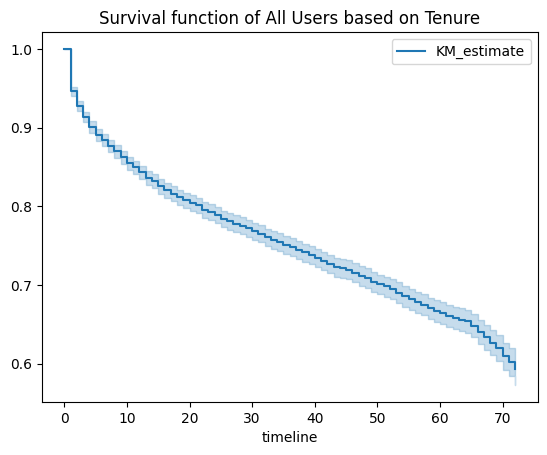

In [26]:
from matplotlib import pyplot as plt


kmf.plot_survival_function()
plt.title('Survival function of All Users based on Tenure')

#### Is there gender difference ??


#### Label Encoding

In [ ]:
#import Label Encoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
dummy_columns = [] #array for multiple value columns
for column in df_data.columns:
    if df_data[column].dtype == object and column != 'customerID':
        if df_data[column].nunique() == 2:
            #apply Label Encoder for binary ones
            df_data[column] = le.fit_transform(df_data[column]) 
        else:
            dummy_columns.append(column)
#apply get dummies for selected columns
df_data = pd.get_dummies(data = df_data,columns = dummy_columns)

### logistic regression

#### Xgboost Classifier

In [2]:
from xgboost import XGBClassifier


#create feature set and labels
X = df_data.drop(['Churn','customerID'],axis=1)
y = df_data.Churn
#train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=56)
#building the model & printing the score
xgb_model = XGBClassifier(max_depth=5, learning_rate=0.08, objective= 'binary:logistic',n_jobs=-1).fit(X_train, y_train)
print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(xgb_model.score(X_test[X_train.columns], y_test)))

ModuleNotFoundError: No module named 'xgboost'

##### Classification report

In [9]:
y_pred = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.91      0.89       267
           1       0.68      0.58      0.63        86

    accuracy                           0.83       353
   macro avg       0.77      0.75      0.76       353
weighted avg       0.82      0.83      0.83       353



We can see a good Precision and recall for the majority class, which is non churn